In [2]:
pip install boto3 --version 1.24.12

ERROR: Could not find a version that satisfies the requirement 1.24.12 (from versions: none)
ERROR: No matching distribution found for 1.24.12
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install sagemaker

In [2]:
%store -r
%store

Stored variables and their in-db values:


In [2]:
import sagemaker
import sagemaker.amazon.common as smac
import boto3

import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
assert sagemaker.__version__ >= "2.21.0"

In [1]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = 'quicksight-pavan-cjp'
print(f"using bucket {bucket} in region {region} \n")

NameError: name 'boto3' is not defined

In [5]:
#Code added to extract data from s3 buckt and use for data cleaning
import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
bucket='quicksight-pavan-cjp'
data_key = 'Online Retail.csv'
df = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(df, encoding="ISO-8859-1")
#df = pd.read_csv(df1, index_col=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
print(df.shape)

(406829, 8)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


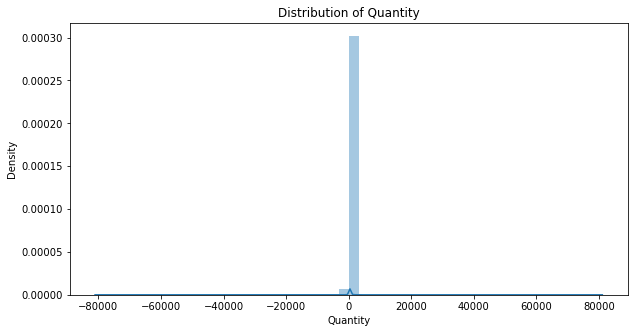

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(df["Quantity"], kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity");

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


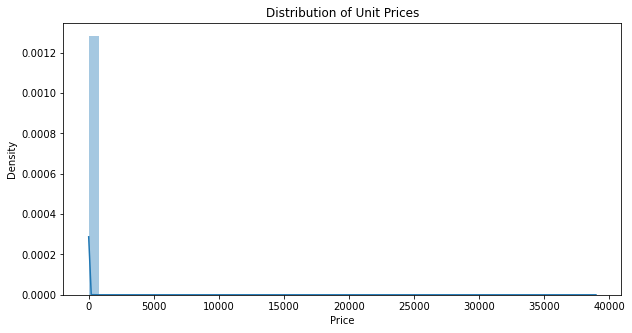

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(df["UnitPrice"], kde=True)
plt.title("Distribution of Unit Prices")
plt.xlabel("Price");

In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [12]:
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
    "Quantity"
].sum()
df = df.loc[df > 0].reset_index()
df.shape

(274399, 6)

In [13]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [14]:
X, y = loadDataset(df)

In [15]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.9991284988048746

In [ ]:
#Prepare Data For Modeling

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

In [21]:
df.to_csv("/home/ec2-user/SageMaker/Retail/data/online_retail_preprocessed.csv", index=False)
save_npz("/home/ec2-user/SageMaker/Retail/data/X_train.npz", X_train)
save_npz("/home/ec2-user/SageMaker/Retail/data/X_test.npz", X_test)
np.savez("/home/ec2-user/SageMaker/Retail/data/y_train.npz", y_train)
np.savez("/home/ec2-user/SageMaker/Retail/data/y_test.npz", y_test)

In [22]:
prefix = "personalization"

train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [23]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)


train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))

s3://quicksight-pavan-cjp/personalization/train/train.protobuf
s3://quicksight-pavan-cjp/personalization/test/test.protobuf
Output: s3://quicksight-pavan-cjp/personalization/output


In [24]:
%store train_data_location
%store test_data_location

Stored 'train_data_location' (str)
Stored 'test_data_location' (str)
